<a href="https://colab.research.google.com/github/edog105git/CS230/blob/main/Test_SegNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# this mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import PIL
import tensorflow as tf
import numpy as np
import os
import pandas as pd

In [ ]:
! pip install git+https://github.com/tensorflow/examples.git

  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-1d6tred5
  Running command git clone -q https://github.com/tensorflow/examples.git /tmp/pip-req-build-1d6tred5
  Created wheel for tensorflow-examples: filename=tensorflow_examples-ef9fcf969bc2f6a848ad69cfcd5f1dcd9474a1fb_-py3-none-any.whl size=299204 sha256=c5767c1da1f81d8dd99b6159137c3eb97f9bf861a8851c12c6732afef1ed400b
  Stored in directory: /tmp/pip-ephem-wheel-cache-8eplt699/wheels/eb/19/50/2a4363c831fa12b400af86325a6f26ade5d2cdc5b406d552ca
Failed to build tensorflow-examples
    Running setup.py install for tensorflow-examples ... done
  DEPRECATION: tensorflow-examples was installed using the legacy 'setup.py install' method, because a wheel could not be built for it. A possible replacement is to fix the wheel build issue reported above. You can find discussion regarding this at https://github.com/pypa/pip/issues/8368.


In [ ]:
from tensorflow_examples.models.pix2pix import pix2pix

In [ ]:
# data path for saving the organized training data
save_path = '/content/drive/Shared drives/CS230 project/Organized Data/Processed'
df = pd.read_csv(os.path.join(save_path, 'OT_train.csv'), header=None)
OT_Train = df.to_numpy().reshape(438, 256, 256, 1)
df = pd.read_csv(os.path.join(save_path, 'NCCT_train.csv'), header=None)
CT_Train = df.to_numpy().reshape(438, 256, 256, 1)

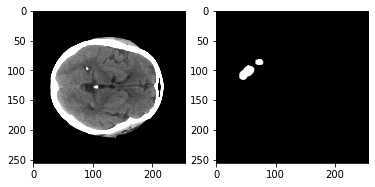

In [ ]:
import matplotlib.pyplot as plt
plt.subplot(1,2,1)
plt.imshow(CT_Train[3,:,:,0],cmap='gray', vmin=0, vmax=100)
plt.subplot(1,2,2)
plt.imshow(OT_Train[3,:,:,0],cmap='gray', vmin=0, vmax=1)

In [ ]:
# https://www.tensorflow.org/tutorials/images/segmentation
# tensor-flow unet

base_model = tf.keras.applications.MobileNetV2(input_shape=[256, 256, 3], include_top=False)
tf.keras.utils.plot_model(base_model, show_shapes=True)
base_model.trainable = True

In [ ]:
# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 128x128
    'block_3_expand_relu',   # 64x64
    'block_6_expand_relu',   # 32x32
    'block_13_expand_relu',  # 16x16
    'block_16_project',      # 8x8
    ]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

down_stack.trainable = True

In [ ]:
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

In [ ]:
def unet_model(output_channels:int):
  inputs = tf.keras.layers.Input(shape=[256, 256, 3])

  # Downsampling through the model
  skips = down_stack(inputs)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      filters=output_channels, kernel_size=3, strides=2,
      padding='same')  #64x64 -> 128x128

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [ ]:
OT_Train1 = OT_Train * 0.99

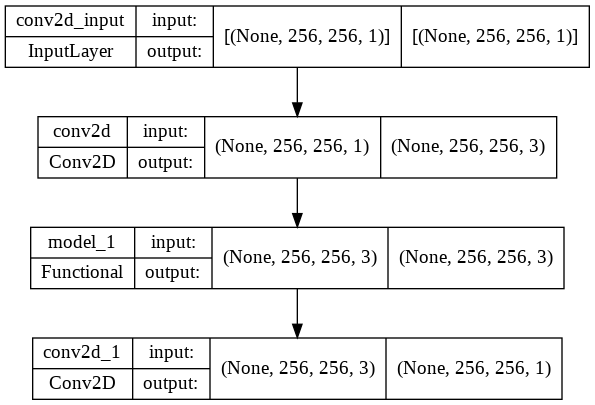

In [ ]:
OUTPUT_CLASSES = 3
train_shape = 256, 256, 1
model = tf.keras.Sequential()
model.add(tf.keras.layers.Conv2D(filters=3, kernel_size=3, strides=1, padding='same', data_format='channels_last',input_shape=train_shape))
model.add(unet_model(output_channels=OUTPUT_CLASSES))
model.add(tf.keras.layers.Conv2D(filters=1, kernel_size=3, strides=1, padding='same'))
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
# https://lars76.github.io/2018/09/27/loss-functions-for-segmentation.html
def dice_loss(y_true, y_pred):
  y_true = tf.cast(y_true, tf.float32)
  y_pred = tf.math.sigmoid(y_pred)
  numerator = 2 * tf.reduce_sum(y_true * y_pred)
  denominator = tf.reduce_sum(y_true + y_pred)

  return 1 - numerator / denominator
  
def weighted_cross_entropy(beta):
  def loss(y_true, y_pred):
    weight_a = beta * tf.cast(y_true, tf.float32)
    weight_b = 1 - tf.cast(y_true, tf.float32)
    
    o = (tf.math.log1p(tf.exp(-tf.abs(y_pred))) + tf.nn.relu(-y_pred)) * (weight_a + weight_b) + y_pred * weight_b 
    return tf.reduce_mean(o)

  return loss

initial_learning_rate = 0.0001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True)

In [ ]:

model.compile(optimizer=tf.keras.optimizers.Adam(
    learning_rate=0.000001),
              loss=weighted_cross_entropy(beta = 5000),
              metrics=['binary_accuracy'])

In [ ]:
model_history = model.fit(x = CT_Train, y = OT_Train, batch_size=40, epochs = 5, verbose='auto')

Epoch 1/5
11/11 [==============================] - 6s 504ms/step - loss: 0.3323 - binary_accuracy: 0.9796
Epoch 2/5
11/11 [==============================] - 6s 503ms/step - loss: 0.3357 - binary_accuracy: 0.9797
Epoch 3/5
11/11 [==============================] - 6s 506ms/step - loss: 0.3317 - binary_accuracy: 0.9797
Epoch 4/5
11/11 [==============================] - 6s 510ms/step - loss: 0.3307 - binary_accuracy: 0.9798
Epoch 5/5
11/11 [==============================] - 6s 515ms/step - loss: 0.3220 - binary_accuracy: 0.9798


In [ ]:
pred_OT=model.predict(CT_Train)


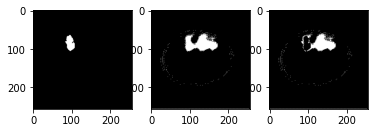

In [ ]:
ind = 27
plt.subplot(1,3,1)
plt.imshow(OT_Train[ind,:,:,0],cmap='gray', vmin=0, vmax=1)
plt.subplot(1,3,2)
pred_map = np.zeros(pred_OT[ind,:,:,0].shape)
pred_map[pred_OT[ind,:,:,0]>0.5] = 1
plt.imshow(pred_map,cmap='gray', vmin=0, vmax=1)
plt.subplot(1,3,3)
plt.imshow(np.abs(pred_map - OT_Train[ind,:,:,0]),cmap='gray', vmin=0, vmax=1)

In [ ]:
a = np.amin(OT_Train)
b = np.amin(pred_OT)
print(b)

-7.6596656


In [ ]:
# save model
model_path = '/content/drive/Shared drives/CS230 project/UNet_MobileV2'
model.save(model_path)

INFO:tensorflow:Assets written to: /content/drive/Shared drives/CS230 project/UNet_MobileV2/assets


In [ ]:
#load model
model_path = '/content/drive/Shared drives/CS230 project/UNet_MobileV2'
model = tf.keras.models.load_model(model_path, compile=False)
model.trainable = False

In [ ]:
# prediction
pred_OT=model.predict(CT_Train)
pred_OT_S = tf.math.sigmoid(pred_OT)

In [ ]:
# compute recall
m = tf.keras.metrics.Recall(thresholds = 0.5)
m.update_state(OT_Train, pred_OT_S)
m.result().numpy()

0.56015027

In [ ]:
# compute precision
m = tf.keras.metrics.Precision(thresholds = 0.5)
m.update_state(OT_Train, pred_OT_S)
m.result().numpy()

0.28202066

In [ ]:
# compute dice score
print(dice_loss(OT_Train, pred_OT))

tf.Tensor(0.93435884, shape=(), dtype=float32)


 https://lars76.github.io/2018/09/27/loss-functions-for-segmentation.html

 https://github.com/Hua-YS/Semantic-Segmentation-with-Sparse-Labels/blob/main/loss.py

https://jeune-research.tistory.com/entry/Loss-Functions-for-Image-Segmentation-Distribution-Based-Losses

https://arxiv.org/pdf/1606.06650.pdf (maybe we can use weighted softmax/cross entropy)